<a href="https://colab.research.google.com/github/Yasmeenrafique/PRODIGY_GA_05/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import copy


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [3]:
def load_image(image_path, max_size=400):
    image = Image.open(image_path).convert('RGB')

    size = max(image.size)
    if size > max_size:
        size = max_size

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor()
    ])

    image = transform(image).unsqueeze(0)
    return image.to(device)


In [4]:
content_img = load_image("beautiful-shoes.jpg")
style_img = load_image("paintingshoes.jpg")


In [5]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:08<00:00, 68.5MB/s]


In [6]:
content_layers = ['conv_4']
style_layers = ['conv_1','conv_2','conv_3','conv_4','conv_5']


In [7]:
def get_features(image, model):
    layers = {
        '0': 'conv_1',
        '5': 'conv_2',
        '10': 'conv_3',
        '19': 'conv_4',
        '28': 'conv_5'
    }

    features = {}
    x = image

    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features


In [8]:
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram


In [9]:
content_features = get_features(content_img, vgg)
style_features = get_features(style_img, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


In [10]:
target = content_img.clone().requires_grad_(True).to(device)


In [11]:
style_weight = 1e6
content_weight = 1


In [12]:
optimizer = optim.Adam([target], lr=0.003)


In [15]:
with torch.no_grad():
    content_features = get_features(content_img, vgg)
    style_features = get_features(style_img, vgg)

style_grams = {}
for k in style_features:
    style_grams[k] = gram_matrix(style_features[k])


In [16]:
content_features = {k: v.detach() for k, v in content_features.items()}
style_grams = {k: v.detach() for k, v in style_grams.items()}


In [17]:
target = content_img.clone().detach().requires_grad_(True).to(device)
optimizer = torch.optim.Adam([target], lr=0.003)


In [18]:
steps = 300

for i in range(steps):

    target_features = get_features(target, vgg)

    content_loss = torch.mean(
        (target_features['conv_4'] - content_features['conv_4']) ** 2
    )

    style_loss = 0
    for layer in style_layers:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]

        _, c, h, w = target_feature.shape
        style_loss += torch.mean((target_gram - style_gram) ** 2) / (c * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if i % 50 == 0:
        print(f"Step {i}, Total Loss: {total_loss.item()}")


Step 0, Total Loss: 27913506.0
Step 50, Total Loss: 6669778.5
Step 100, Total Loss: 2808068.0
Step 150, Total Loss: 1395956.875
Step 200, Total Loss: 843463.6875
Step 250, Total Loss: 573416.0


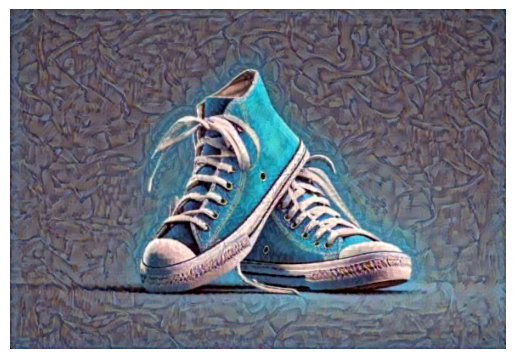

In [19]:
def imshow(tensor):
    image = tensor.cpu().clone().detach().squeeze(0)
    image = image.permute(1,2,0)
    plt.imshow(image)
    plt.axis('off')

imshow(target)
